<div style="margin: 0 auto; padding: 20px; font-family: 'Helvetica', sans-serif; font-size: 16px;">

## Propagation Delay Calculation and flight path distance estimation

In this tutorial we will see how to calculate the $t_0$ with the known sample. To ensure accurate estimation you should select your peak within the big mc range. You should also make your calculation for a small volume specially and for a small variation of voltage. Another pont is that you should choose a narrow window around your peaks.

</div>

In [ ]:
import pandas as pd
# Activate intractive functionality of matplotlib
%matplotlib ipympl
# Activate auto reload 
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
# import libraries
import os
import numpy as np
import subprocess
from sklearn import linear_model
import matplotlib.pyplot as plt
from ipywidgets import fixed, interact_manual, widgets
from ipywidgets import Output
from IPython.display import clear_output

# Local module and scripts
from pyccapt.calibration.calibration import share_variables
from pyccapt.calibration.data_tools import data_tools, data_loadcrop, dataset_path_qt
from pyccapt.calibration.mc import mc_tools
from pyccapt.calibration.tutorials.tutorials_helpers import helper_data_loader
from pyccapt.calibration.calibration import widgets as wd
from pyccapt.calibration.calibration import mc_plot
from pyccapt.calibration.tutorials.tutorials_helpers import helper_t_0_tune

<div style="margin: 0 auto; padding: 20px; font-family: 'Helvetica', sans-serif; font-size: 16px;">
In the cell below we create variable object. This object is used in many of the functions to share the data between functions in as easy way. 
</div>


In [2]:
variables = share_variables.Variables()

<div style="margin: 0 auto; padding: 20px; font-family: 'Helvetica', sans-serif; font-size: 16px;">

By clicking on the button below, you can select the dataset file you want to use. The dataset file can be in various formats, including HDF5, EPOS, POS, ATO, and CSV.
</div>

In [3]:
button = widgets.Button(description='load dataset')

@button.on_click
def open_file_on_click_r(b):
    global dataset_path
    folder_path = variables.last_directory
    script = '..//..//data_tools//run_dataset_path_qt.py'
    cmd = f"python {script} {folder_path}"
    result = subprocess.run(cmd, capture_output=True, text=True, shell=True)
    dataset_path = result.stdout.strip()
    variables.last_directory = dataset_path

button

Button(description='load dataset', style=ButtonStyle())

<div style="margin: 0 auto; padding: 20px; font-family: 'Helvetica', sans-serif; font-size: 16px;">
In case of recieving the error about pytable library, you have to install the pytables library with conda command. to do that you can open a new cell and copy the line below in it. Then just run it like other cells. The pytables library will be innstalled.
    
`!conda install --yes --prefix {sys.prefix} pytables`
</div>


<div style="margin: 0 auto; padding: 20px; font-family: 'Helvetica', sans-serif; font-size: 16px;">
From the dropdown lists below, you can select the instrument specifications of the dataset. The instrument specifications are the same as the ones used for the calibration process. Data mode is specify the dataset structure. The flight path length is the distance between the sample and the detector. The t0 is the time of flight of the ions with the lowest mass-to-charge ratio. The maximum mass-to-charge ratio is the maximum mass-to-charge ratio of tat you want to plot. You can also change it in te related cells. The detector diameter is the diameter of the detector.
</div>


In [8]:
tdc, pulse_mode, flight_path_length, t0, max_mc, det_diam = wd.dataset_instrument_specification_selection()
display(tdc, flight_path_length, pulse_mode, t0, max_mc)

Dropdown(description='Data mode:', options=('pyccapt', 'leap_epos', 'leap_pos', 'leap_apt', 'ato_v6'), value='…

FloatText(value=110.0, description='Flight path length:')

Dropdown(description='Pulse mode:', options=('voltage', 'laser'), value='voltage')

FloatText(value=38.0, description='t0:')

FloatText(value=400.0, description='Max mc:')

In [9]:
# exctract needed data from Pandas data frame as an numpy array
# create an instance of the Variables opject
variables = share_variables.Variables()
variables.pulse_mode = pulse_mode

dataset_main_path = os.path.dirname(dataset_path)
dataset_main_path = os.path.dirname(dataset_main_path)
dataset_name_with_extention = os.path.basename(dataset_path)
variables.dataset_name = os.path.splitext(dataset_name_with_extention)[0]
variables.result_data_path = dataset_main_path + '/t_0_flight_path_distance/'
variables.result_data_name = variables.dataset_name
variables.result_path = dataset_main_path + '/t_0_flight_path_distance/'

if not os.path.isdir(variables.result_path):
    os.makedirs(variables.result_path, mode=0o777, exist_ok=True)

variables = helper_data_loader.load_data(dataset_path, max_mc.value, flight_path_length.value, pulse_mode.value, tdc.value, variables)
data_tools.extract_data(variables.data, variables, flight_path_length.value, max_mc.value)
display(variables.data)

The maximum possible TOF is: 5010 ns
The data will be saved on the path: C:/Users/APTUser/Downloads/Al APT data/Al APT data/5d6eff12-0f37-4cc8-aa39-6a9bb85ba105/data_processing/5d6eff12-0f37-4cc8-aa39-6a9bb85ba105/data_processing/
The dataset name after saving is: 5d6eff12-0f37-4cc8-aa39-6a9bb85ba105
The figures will be saved on the path: C:/Users/APTUser/Downloads/Al APT data/Al APT data/5d6eff12-0f37-4cc8-aa39-6a9bb85ba105/data_processing/5d6eff12-0f37-4cc8-aa39-6a9bb85ba105/data_processing/
{'df': ['axis0', 'axis1', 'block0_items', 'block0_values', 'block1_items', 'block1_values', 'block2_items', 'block2_values']}
The data is loaded in processed mode
Total number of Ions: 40327693
The maximum possible time of flight is: 5010


,x (nm),y (nm),z (nm),mc (Da),mc_uc (Da),high_voltage (V),pulse,t (ns),t_c (ns),x_det (cm),y_det (cm),pulse_pi,ion_pp,start_counter
0,1.907994,-2.437763,-0.237270,27.327838,29.347885,1273.640015,0.0,985.101318,28.949713,0.462487,-0.595060,0,0,0
1,0.331818,-1.943899,-0.095983,27.349383,29.382338,1273.640015,0.0,983.657349,28.973371,0.080935,-0.475299,0,0,0
2,0.518514,-3.230205,-0.265251,27.355988,29.377463,1273.640015,0.0,986.026367,28.979777,0.127184,-0.789671,0,0,0
3,1.610926,-7.241961,-1.403382,27.363877,29.289399,1273.640015,0.0,1001.562378,28.978839,0.404676,-1.826347,0,0,0
4,-9.811413,-3.060770,-2.792088,27.418076,29.204824,1273.640015,0.0,1020.651367,29.025705,-2.528263,-0.793413,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40327688,6.279893,-19.178265,-180.136215,280.987182,319.118572,5345.200195,0.0,1590.693359,319.092982,0.369990,-1.126497,0,0,0
40327689,45.221512,-18.669287,-193.148895,90.235287,98.760770,5345.200195,0.0,927.628296,99.652101,2.794193,-1.156437,0,0,0
40327690,-38.961277,-7.836176,-187.543228,272.348255,307.204343,5345.200195,0.0,1602.559326,308.861081,-2.377955,-0.482784,0,0,0
40327691,6.506674,-31.627668,-184.065109,49.994293,54.315642,5345.200195,0.0,668.562378,54.446230,0.393114,-1.904940,0,0,0


In [10]:
interact_manual(data_loadcrop.plot_crop_experiment_history, data=fixed(variables.data), variables=fixed(variables), max_tof=widgets.FloatText(value=variables.max_tof), frac=widgets.FloatText(value=1.0),
                bins=fixed((1200,800)), figure_size=fixed((7,3)),
               draw_rect=fixed(False), data_crop=fixed(False), pulse_plot=widgets.Dropdown(options=[('False', False), ('True', True)]), dc_plot=widgets.Dropdown(options=[('True', True), ('False', False)]),
                pulse_mode=widgets.Dropdown(options=[('voltage', 'voltage'), ('laser', 'laser')]), save=widgets.Dropdown(options=[('True', True), ('False', False)]),
               figname=widgets.Text(value='exp_hist'));

C:\Users\APTUser\AppData\Local\Temp\ipykernel_27920\1690469077.py:1: DeprecationWarning: on_submit is deprecated. Instead, set the .continuous_update attribute to False and observe the value changing with: mywidget.observe(callback, 'value').
  interact_manual(data_loadcrop.plot_crop_experiment_history, data=fixed(variables.data), variables=fixed(variables), max_tof=widgets.FloatText(value=variables.max_tof), frac=widgets.FloatText(value=1.0),


interactive(children=(FloatText(value=5010.0, description='max_tof'), FloatText(value=1.0, description='frac')…

<div style="margin: 0 auto; padding: 20px; font-family: 'Helvetica', sans-serif; font-size: 16px;">

Extract the data from the dataset file in numpy array format.
</div>

In [11]:
# exctract needed data from Pandas data frame as an numpy array

# exctract needed data from Pandas data frame as an numpy array
variables.dld_high_voltage = variables.data['high_voltage (V)'].to_numpy()
variables.dld_pulse = variables.data['pulse'].to_numpy()
variables.dld_t = variables.data['t (ns)'].to_numpy()
variables.dld_x_det = variables.data['x_det (cm)'].to_numpy()
variables.dld_y_det = variables.data['y_det (cm)'].to_numpy()

<div style="margin: 0 auto; padding: 20px; font-family: 'Helvetica', sans-serif; font-size: 16px;">

In the next cell by changing the t<sub>0</sub> value you can correct the position of H<sub>1</sub> or any other known peak. this correction would be helpful for the position of the peaks in the m/c calibration process.
</div>

In [12]:
helper_t_0_tune.call_fine_tune_t_0(variables, flight_path_length, pulse_mode, t0)

Output()

<div style="margin: 0 auto; padding: 20px; font-family: 'Helvetica', sans-serif; font-size: 16px;">

Remove the data with m/c greater than max m/c and x, y, t = 0. Also add the needed colums for calibration. The data types of the final cropped dataset is displayed below.

</div>

In [13]:
# add the columns in the dataset for x, y, z, mc, mc calibrated, and t calibrated
helper_data_loader.add_columns(variables, max_mc)
# again extract the update data to the variables
data_tools.extract_data(variables.data, variables, flight_path_length.value, max_mc.value)
display(variables.data)

The number of data over max_mc: 0
The number of data with having t, x, and y equal to zero is: 0
The maximum possible time of flight is: 5010


,x (nm),y (nm),z (nm),mc (Da),mc_uc (Da),high_voltage (V),pulse,t (ns),t_c (ns),x_det (cm),y_det (cm),pulse_pi,ion_pp,start_counter
0,1.907994,-2.437763,-0.237270,27.327838,29.648086,1273.640015,0.0,985.101318,28.949713,0.462487,-0.595060,0,0,0
1,0.331818,-1.943899,-0.095983,27.349383,29.683336,1273.640015,0.0,983.657349,28.973371,0.080935,-0.475299,0,0,0
2,0.518514,-3.230205,-0.265251,27.355988,29.677683,1273.640015,0.0,986.026367,28.979777,0.127184,-0.789671,0,0,0
3,1.610926,-7.241961,-1.403382,27.363877,29.584040,1273.640015,0.0,1001.562378,28.978839,0.404676,-1.826347,0,0,0
4,-9.811413,-3.060770,-2.792088,27.418076,29.493079,1273.640015,0.0,1020.651367,29.025705,-2.528263,-0.793413,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40327688,6.279893,-19.178265,-180.136215,280.987182,321.134231,5345.200195,0.0,1590.693359,319.092982,0.369990,-1.126497,0,0,0
40327689,45.221512,-18.669287,-193.148895,90.235287,99.834099,5345.200195,0.0,927.628296,99.652101,2.794193,-1.156437,0,0,0
40327690,-38.961277,-7.836176,-187.543228,272.348255,309.130312,5345.200195,0.0,1602.559326,308.861081,-2.377955,-0.482784,0,0,0
40327691,6.506674,-31.627668,-184.065109,49.994293,55.137273,5345.200195,0.0,668.562378,54.446230,0.393114,-1.904940,0,0,0


<div style="margin: 0 auto; padding: 20px; font-family: 'Helvetica', sans-serif; font-size: 16px;">

plot the histogram of the mass spectrum select the peak that you want to use for t_0 calibration. preferably, the peaks have to be chosen from low to high mass.
</div>

In [31]:
interact_manual(
        mc_plot.hist_plot,
        variables=fixed(variables),
        bin_size=widgets.FloatText(value=0.1),
        log=widgets.Dropdown(options=[('True', True), ('False', False)]),
        target=widgets.Dropdown(options=[('mc_calib', 'mc_calib'), ('tof_calib', 'tof_calib')]),
        mode=widgets.Dropdown(options=[('normal', 'normal'), ('normalized', 'normalized')]),
        prominence=widgets.IntText(value=100),
        distance=widgets.IntText(value=100),
        percent=widgets.IntText(value=50),
        selector=fixed('peak'),
        figname=widgets.Text(value='hist'),
        lim=widgets.IntText(value=variables.max_mc),
        peaks_find=widgets.Dropdown(options=[('True', True), ('False', False)]),
        peaks_find_plot=widgets.Dropdown(options=[('True', True), ('False', False)]),
        plot_ranged_peak=fixed(False),
        plot_ranged_colors=fixed(False),
        mrp_all=fixed(False),
        background=fixed(None),
        ranging_mode=fixed(False),
        range_sequence=fixed([]),
        range_mc=fixed([]),
        range_detx=fixed([]),
        range_dety=fixed([]),
        range_x=fixed([]),
        range_y=fixed([]),
        range_z=fixed([]),
        range_vol=fixed([]),
        save_fig=widgets.Dropdown(options=[('True', True), ('False', False)]),
        print_info=fixed(True),
        legend_mode=fixed('long'),
        draw_calib_rect=fixed(False),
        figure_size=fixed((9, 5)),
        plot_show=fixed(True));


C:\Users\APTUser\AppData\Local\Temp\ipykernel_27920\4281687215.py:1: DeprecationWarning: on_submit is deprecated. Instead, set the .continuous_update attribute to False and observe the value changing with: mywidget.observe(callback, 'value').
  interact_manual(


interactive(children=(FloatText(value=0.1, description='bin_size'), Dropdown(description='log', options=(('Tru…

<div style="margin: 0 auto; padding: 20px; font-family: 'Helvetica', sans-serif; font-size: 16px;">

For the selected peak you have to select the mass-to-charge ratio of the peak. You can select the mass-to-charge ratio from the dropdown list below. You can also select the charge of the peak. After that you can add the peak to the list by clicking on the add button. You can also delete the selected peak from the list by clicking on the delete button. You can reset the list by clicking on the reset button.

</div>


In [32]:
isotopeTableFile = '../../../files/isotopeTable.h5'
dataframe =  pd.read_hdf(isotopeTableFile, mode='r')
elementsList = dataframe['element']
elementIsotopeList = dataframe['isotope']
elementMassList =  dataframe['weight']
abundanceList = dataframe['abundance']

elements = list(zip(elementsList, elementIsotopeList, elementMassList, abundanceList))
dropdownList = []
for element in elements:
    tupleElement = ("{} ({}) ({:.2f})".format(element[0], element[1], element[3]), "{}({})[{}]".format(element[0], element[1], element[2]))
    dropdownList.append(tupleElement)

chargeList = [(1,1,),(2,2,),(3,3,),(4,4,)]
dropdown = wd.dropdownWidget(dropdownList,"Elements")
dropdown.observe(wd.on_change)


chargeDropdown = wd.dropdownWidget(chargeList,"Charge")
chargeDropdown.observe(wd.on_change_charge)

wd.compute_element_isotope_values_according_to_selected_charge()

buttonAdd = wd.buttonWidget("ADD")
buttonDelete = wd.buttonWidget("DELETE")
buttonReset = wd.buttonWidget("RESET")

display(dropdown, chargeDropdown, buttonAdd, buttonDelete, buttonReset)

def buttonAdd_f(b,):
    with out:
        clear_output(True)
        wd.onClickAdd(b, variables)
        display()
def buttonDelete_f(b,):
    with out:
        clear_output(True)
        wd.onClickDelete(b, variables)
        display()
def buttonResett_f(b,):
    with out:
        clear_output(True)
        wd.onClickReset(b, variables)
        display()

listMaterial = buttonAdd.on_click(buttonAdd_f)
buttonDelete.on_click(buttonDelete_f)
buttonReset.on_click(buttonResett_f)
# listMaterial = buttonAdd.on_click(wd.onClickAdd)
# buttonDelete.on_click(wd.onClickDelete)
# buttonReset.on_click(wd.onClickReset)
out = Output()
display(out)

Dropdown(description='Elements', options=(('H (1) (99.98)', 'H(1)[1.01]'), ('H (2) (0.01)', 'H(2)[2.01]'), ('H…

Dropdown(description='Charge', options=((1, 1), (2, 2), (3, 3), (4, 4)), value=1)

Button(description='ADD', icon='check', style=ButtonStyle(), tooltip='ADD')

Button(description='DELETE', icon='check', style=ButtonStyle(), tooltip='DELETE')

Button(description='RESET', icon='check', style=ButtonStyle(), tooltip='RESET')

Output()

In [34]:
# The correct peak location based on your sample
peaks_ideal = variables.list_material
print('peak ideal mass:', peaks_ideal)
peak_x = variables.peaks_x_selected
print('peak actual mass:', peak_x)
print('The peak index are:', variables.peaks_index_list)

peak ideal mass: [1.01, 13.49, 26.98]
peak actual mass: [1.0086208708446214, 29.341163554070462]
The peak index are: [0, 14]


<div style="margin: 0 auto; padding: 20px; font-family: 'Helvetica', sans-serif; font-size: 16px;">

Here for each peak a mask will be created.
</div>


In [35]:
pick_ions_plot = []
mask = np.zeros(len(variables.mc_uc), dtype=bool)
mc_seb_ideal = np.zeros(len(variables.mc_uc))
# creat mask for each peak base on the peak loc. and window size
index = 0
for i in variables.peaks_index_list:
    mask_tmp = np.logical_and((variables.x_hist[round(variables.peak_widths[2][i])] < variables.mc_uc), (variables.mc_uc < variables.x_hist[round(variables.peak_widths[3][i])]))
    # Count the number of True values in the original mask_tmp
    true_indices = np.where(mask_tmp)[0]
    num_true_values = len(true_indices)

    # If there are more than 5000 True values, randomly choose 5000 of them
    if num_true_values > 5000:
        selected_indices = np.random.choice(true_indices, size=5000, replace=False)

        # Create a new mask with the same length as the original, initialized with False
        new_mask = np.full_like(mask_tmp, False)

        # Set the selected indices to True in the new mask
        new_mask[selected_indices] = True

        # Update the original mask_tmp with the new mask
        mask_tmp = new_mask
    
    print('peak left and right sides are:', variables.x_hist[round(variables.peak_widths[2][i])], variables.x_hist[round(variables.peak_widths[3][i])])
    mask = np.logical_or(mask, mask_tmp)
    mc_seb_ideal[mask_tmp==True] = peaks_ideal[index]
    index += 1
    bb = np.zeros(len(variables.mc_uc))
    
    pick_ions_plot.append(mask_tmp)


peak left and right sides are: 1.0086208708446214 1.1087358626581403
peak left and right sides are: 29.040818578629906 29.441278545883982


<div style="margin: 0 auto; padding: 20px; font-family: 'Helvetica', sans-serif; font-size: 16px;">

Here we plot ions in each peak base on the TOF and (x,y) position
</div>


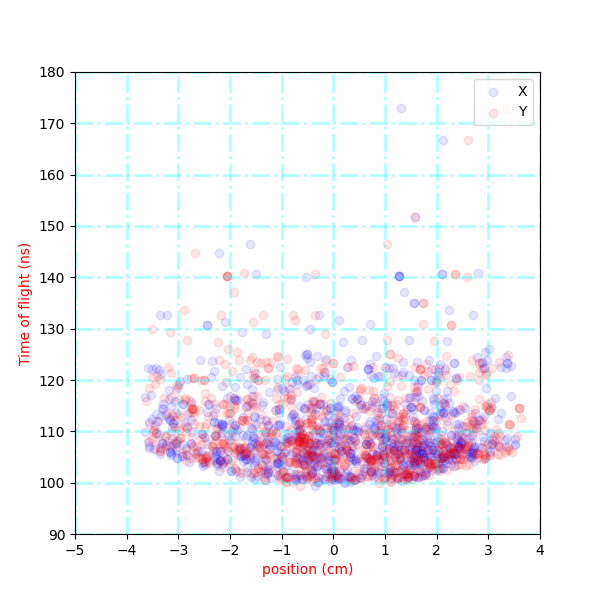

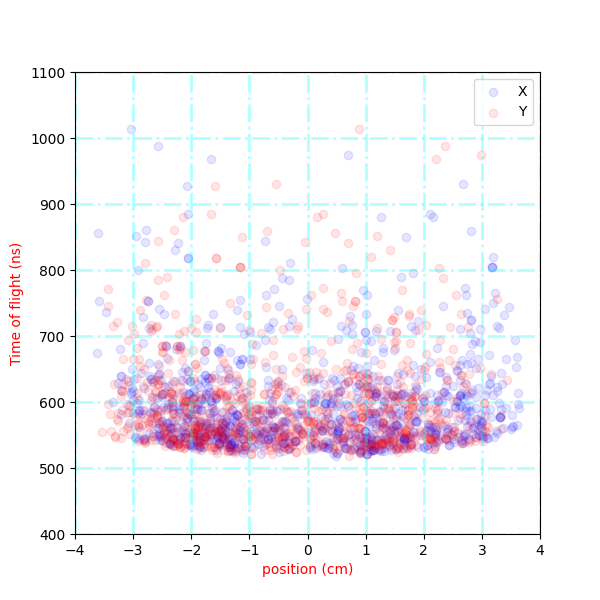

In [36]:
for i in range(len(pick_ions_plot)):
    fig1, ax1 = plt.subplots(figsize=(6, 6))
    dld_x_masked = variables.dld_x_det[pick_ions_plot[i]]
    dld_y_masked = variables.dld_y_det[pick_ions_plot[i]]
    dld_t_masked = variables.dld_t[pick_ions_plot[i]]
    if len(dld_x_masked) > 1000:
        mask_plot = np.random.randint(0, len(dld_x_masked), 1000)
        x = plt.scatter(dld_x_masked[mask_plot], dld_t_masked[mask_plot], color="blue", label='X', alpha=0.1)
        y = plt.scatter(dld_y_masked[mask_plot], dld_t_masked[mask_plot], color="red", label='Y', alpha=0.1)
    else:
        x = plt.scatter(dld_x_masked, dld_t_masked, color="blue", label='X', alpha=0.1)
        y = plt.scatter(dld_y_masked, dld_t_masked, color="red", label='Y', alpha=0.1)
    ax1.set_ylabel("Time of flight (ns)", color="red", fontsize=10)
    ax1.set_xlabel("position (cm)", color="red", fontsize=10)
    plt.grid(color='aqua', alpha=0.3, linestyle='-.', linewidth=2)
    plt.legend(handles=[x, y], loc='upper right')
    plt.ylim(bottom=plt.yticks()[0][0], top=plt.yticks()[0][-1])
    plt.xlim(left=plt.xticks()[0][0], right=plt.xticks()[0][-1])
    plt.savefig(variables.result_path + 'position_peak.png', format="png", dpi=600)
    plt.savefig(variables.result_path + 'position_peak.svg', format="svg", dpi=600)
    plt.show()

<div style="margin: 0 auto; padding: 20px; font-family: 'Helvetica', sans-serif; font-size: 16px;">

As you saw the TOF changes base on the (x,y) of the events. Therefore we creat a mask to only select the ions in center (8m
m*8mm) of detector. This helps to cansel out the variation in TOF due to hit position.
    
<br>Reformulate the equation:<br>
</div>
$$t = d(\sqrt{\frac{\frac{m}{n}}{2eV}})-t_{0} $$<br>

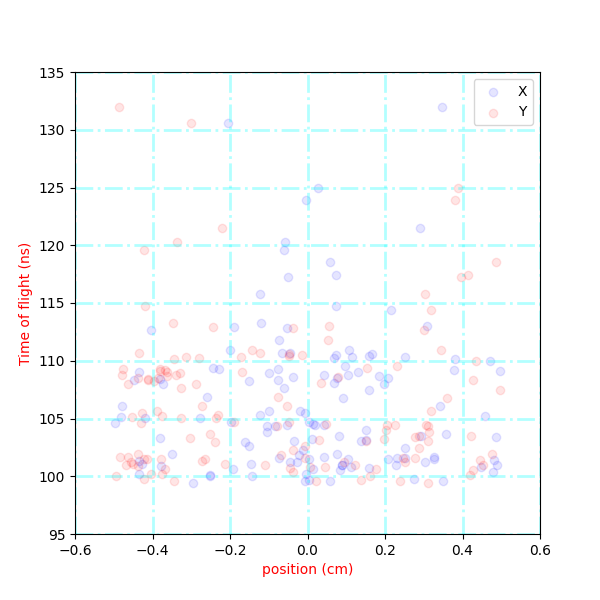

In [37]:
# use mask_equal to have equal number of ions for each peak
# only peak the value in the center of detector 10mm * 10mm
detector_squre = 0.5
vol_variation = 5500 # peak only for 200 voltage variation for vol_variation +/- 100 

fig1, ax1 = plt.subplots(figsize=(6, 6))
dld_x_masked = variables.dld_x_det[mask]
dld_y_masked = variables.dld_y_det[mask]
dld_t_masked = variables.dld_t[mask]
dld_highVoltage_masked = variables.dld_high_voltage[mask]
dld_pulse_masked = variables.dld_pulse[mask]

mask_tmp_middle = np.logical_and((np.abs(dld_x_masked) < detector_squre), (np.abs(dld_y_masked) < detector_squre))
mask_tmp_mvoltage = mask_tmp_mvoltage = np.logical_and((dld_highVoltage_masked < (np.mean(dld_highVoltage_masked)+200)), (dld_highVoltage_masked > (np.mean(dld_highVoltage_masked)-200)))
mask_tmp_mvoltage = np.ones(len(mask_tmp_middle), dtype=bool)
mask_f = np.logical_and(mask_tmp_mvoltage, mask_tmp_middle)

dld_x_masked = dld_x_masked[mask_f]
dld_y_masked = dld_y_masked[mask_f]
dld_t_masked = dld_t_masked[mask_f]
dld_highVoltage_masked = dld_highVoltage_masked[mask_f]
dld_pulse_masked = dld_pulse_masked[mask_f]

mc_seb_reg_masked = mc_seb_ideal[mask]
mc_seb_reg_masked = mc_seb_reg_masked[mask_f]

x = plt.scatter(dld_x_masked, dld_t_masked, color="blue", label='X', alpha=0.1)
y = plt.scatter(dld_y_masked, dld_t_masked, color="red", label='Y', alpha=0.1)
ax1.set_ylabel("Time of flight (ns)", color="red", fontsize=10)
ax1.set_xlabel("position (cm)", color="red", fontsize=10)
plt.grid(color='aqua', alpha=0.3, linestyle='-.', linewidth=2)
plt.legend(handles=[x, y], loc='upper right')
plt.ylim(bottom=plt.yticks()[0][0], top=plt.yticks()[0][-1])
plt.xlim(left=plt.xticks()[0][0], right=plt.xticks()[0][-1])
plt.savefig(variables.result_path + 'center.png' , format="png", dpi=600)
plt.savefig(variables.result_path + 'center.svg' , format="svg", dpi=600)

plt.show()


<div style="margin: 0 auto; padding: 20px; font-family: 'Helvetica', sans-serif; font-size: 16px;">

We calculate the ${t_0}$ base on:
</div>
$$t_{0} = \frac{\sum_{n=1}^n{\left (t - L_{flight}  \sqrt{\frac{m/n}{2eV}} \right )}}{n}$$<br>

In [38]:
seb_t = dld_t_masked * 1E-9  # tof in s
                                                               
seb_factor = np.sqrt(mc_seb_reg_masked * 1.66E-27 / (2 * 1.6E-19 * dld_highVoltage_masked))

seb_factor = seb_factor * 1E6
seb_t = seb_t * 1E9

t0_seb_fixed = np.mean(np.array([seb_t]).squeeze(0) - (flight_path_length.value * np.array([seb_factor]).squeeze(0).reshape(-1, 1)))
print('Linear fixed path lenght -- the flight path lenght(slop): {:.2f}'.format(flight_path_length.value), '(mm)', '\nthe corrected t_0(intercept): {:.2f}'.format(t0_seb_fixed), '(ns)')


Linear fixed path lenght -- the flight path lenght(slop): 90.00 (mm) 
the corrected t_0(intercept): 3.60 (ns)


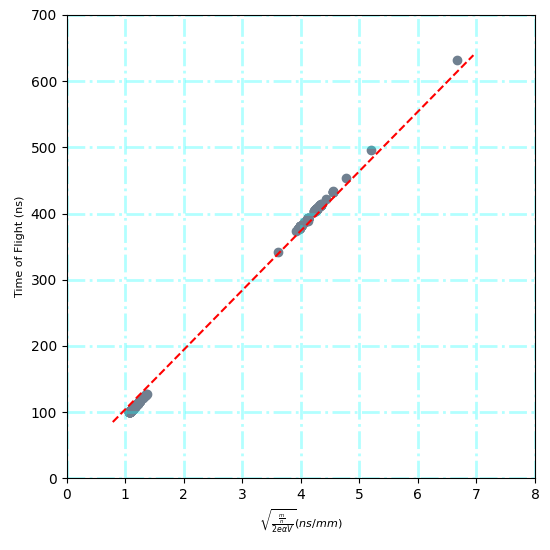

In [28]:
# Plot outputs
# fig1, ax1 = plt.subplots(figsize=(5.5/2.54, 5.5/2.54))
fig1, ax1 = plt.subplots(figsize=(5.5, 5.5))
peaks_data = plt.scatter(seb_factor, seb_t, label='Ions', alpha=1, color='slategray')
axes = plt.gca()
x_vals = np.array(axes.get_xlim())

linear_fix, = plt.plot(x_vals, t0_seb_fixed + flight_path_length.value * x_vals, '--', color='red', label='line' )

plt.grid(color='aqua', alpha=0.3, linestyle='-.', linewidth=2)
# plt.legend(handles=[linear_fix, peaks_data], loc='lower right')

ax1.set_ylabel("Time of Flight (ns)", fontsize=8)

ax1.set_xlabel(r"$\sqrt{\frac{\frac{m}{n}}{2e \alpha V}} (ns/mm)$", fontsize=8)
plt.tight_layout()
plt.ylim(bottom=plt.yticks()[0][0], top=plt.yticks()[0][-1])
plt.xlim(left=plt.xticks()[0][0], right=plt.xticks()[0][-1])
plt.savefig(variables.result_path + 'fixed_flight_path.svg', format="svg", dpi=600)
plt.savefig(variables.result_path + 'fixed_flight_path.png', format="png", dpi=600)

plt.show()

In [29]:
linear = linear_model.LinearRegression()
linear.fit(np.array([seb_factor]).squeeze(0).reshape(-1, 1), np.array([seb_t]).squeeze(0))
d_seb = linear.coef_.item()
t0_seb = linear.intercept_.item()

print('Linear -- the corrected flight path lenght(slop): {:.2f}'.format(d_seb), '(mm)', '\nthe corrected t_0(intercept): {:.2f}'.format(t0_seb), '(ns)')

Linear -- the corrected flight path lenght(slop): 96.00 (mm) 
the corrected t_0(intercept): -3.21 (ns)


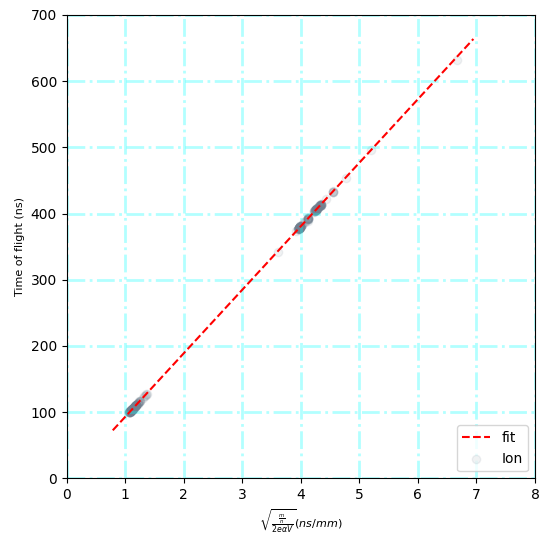

In [30]:
# Plot outputs

# fig1, ax1 = plt.subplots(figsize=(5.5/2.54, 5.5/2.54))
fig1, ax1 = plt.subplots(figsize=(5.5, 5.5))
peaks_data = plt.scatter(seb_factor, seb_t, color="slategray", label='Ion', alpha=0.1)
axes = plt.gca()
x_vals = np.array(axes.get_xlim())


linear, = plt.plot(x_vals, t0_seb + d_seb * x_vals, '--', color='r', label='fit' )


plt.grid(color='aqua', alpha=0.3, linestyle='-.', linewidth=2)

# plt.legend(handles=[peaks_data, linear, rigid, huber,lasso], loc='lower right')
ax1.set_ylabel("Time of flight (ns)", fontsize=8)
ax1.set_xlabel(r"$\sqrt{\frac{\frac{m}{n}}{2e \alpha V}} (ns/mm)$", fontsize=8)
plt.legend(handles=[linear, peaks_data], loc='lower right')
plt.tight_layout()
plt.ylim(bottom=plt.yticks()[0][0], top=plt.yticks()[0][-1])
plt.xlim(left=plt.xticks()[0][0], right=plt.xticks()[0][-1])

plt.savefig(variables.result_path + 'regression.svg', format="svg", dpi=600)
plt.savefig(variables.result_path + 'regression.png', format="png", dpi=600)
    

plt.show()

<div style="margin: 0 auto; padding: 20px; font-family: 'Helvetica', sans-serif; font-size: 16px;">

Plot the m/c with new ${t_0}$:
</div>

In [ ]:
# recalulate the mc based on the new t_0
t_0_f = 737
mc = mc_tools.tof2mc(variables.dld_t, t_0_f, variables.dld_high_voltage, variables.dld_x_det, variables.dld_y_det, flightPathLength_d.value, 
                                         variables.dld_pulse, mode=pulse_mode.value)

mc_hist = mc_plot.AptHistPlotter(mc[mc < 40], variables)
y, x = mc_hist.plot_histogram(bin_width=0.1, label='mc', steps='stepfilled', log=True, grid=True, fig_size=(9, 5))
peaks, properties, peak_widths, prominences = mc_hist.find_peaks_and_widths(prominence=100, distance=10, percent=50)
mc_hist.plot_peaks()
mc_hist.plot_hist_info_legend(label='mc', bin=0.1, background=None, loc='right') 